# 【E検定対策】 K最近傍法(K-Nearest Neighbor) 分類 基礎
本Jupyter Notebookではscikit-learnを用いた分類手法の内、k最近傍法（以下k-NN)の基礎について記載します。

k-NNはもっとも単純な分類アルゴリズムであり、予測したいデータと距離の近いk個のモデルデータのラベルから予測値を決定するアルゴリズムです。

**<メリット>**
- モデルの過度な調整無しにある程度の精度が出る
- アルゴリズムの理解が容易

**<デメリット>**
- データの前処理が必須
- 特徴量（数百以上)の多いデータセットでは上手く機能しない
- 疎なデータセットでは精度が出ない
- 処理速度が遅い

上記デメリットから実務上あまり使われることはありませんが、E検定では出題されますので、分類の基礎知識として必須です。

<img src="https://brainsnacks.org/wp-content/uploads/2020/09/sklern_2.png" height="500" stype="padding:20px;align: right"/>

**k-NN Classifier パラメータ詳細**<br>
scikit-lernにおけるk-NN法文法は以下を参照ください。<br>
=>   [scikit-learn (k-NN_Classifier)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
<br>

<img src="https://brainsnacks.org/wp-content/uploads/2020/09/sklern_1.png" height="360" stype="padding:20px;align: right"/>

## 1. 必要なライブラリの読み込み
実際にsklearnのcancer datasetを用いて分類予測を行います。

まず機械学習予測に必要な必要なライブラリを読み込みます。
"classfication_report"は予測値の評価に用います。



In [46]:
#　必要なライブラリの読み込み
# Jupyter Notebook上にグラフを表記するために記載
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#　訓練データ/教師データの分割用
from sklearn.model_selection import train_test_split
#　予測値の評価用　
from sklearn.metrics import classification_report

#sklean cancer dataの読み込み
from sklearn.datasets import load_breast_cancer

# 2. Cancer Datasetの確認

scikit-learnの提供する乳がんの分類データセットを使用します。<br>
データセットの詳細はこちら=> [scikit-learn Breast Cancer Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)
<br>以下でデータの詳細を確認しましょう。

In [47]:
dataset = load_breast_cancer()

# 特徴量 (説明変数)
X = pd.DataFrame(dataset.data,
                 columns=dataset.feature_names)
#ラベル（目的変数)
y = pd.Series(dataset.target, name='y')

# データ詳細確認
print('X shape: (%i,%i)' %X.shape)
print(y.value_counts())
display(X.join(y).head())

X shape: (569,30)
1    357
0    212
Name: y, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


上記からわかるようにsklearn cancer datasetには説明変数(特徴量)が30、569のデータポイントがあります。<br>
目的変数(ラベル)のうち**"1"が良性の腫瘍、"0"が悪性の腫瘍**を示します。

# 3. CancerDataの前処理

Cancer Datasetの前処理として**標準化**を行います。<br>
標準化とはデータの平均を0に、分散/標準偏差を1にする前処理であり、
各説明変数の目的変数選択への相関レベルを同一にします。<br>
一つの説明変数の重要度に選択を引っ張られないようにすることと理解ください。

相関関係から良性、悪性の判断のために重要と思われる説明変数を絞り込む次元削減を前処理として行うことも多いですが、今回は説明変数の数が30しかないので次元削減は行いません。

In [52]:
from sklearn.preprocessing import StandardScaler

#StandardScalerにて標準化処理を行う
scaler = StandardScaler()
scaler.fit(X)
X_1 = pd.DataFrame(scaler.transform(X),columns=dataset.feature_names)

#標準化したX_1データを表示
display(X_1.join(y).head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0


# 4. k-NNによる分類予測モデルの構築

k-NNを用いて標準化を行ったCancerDatasetの分類モデルを構築します。<br><br>
scikit-Learnにおけるtrain_test_splitを用いて訓練データとテストデータ用にX_1データを分割します。<br>
今回は訓練データをX_1の80%(569x0.8=455)、テストデータをX_1の20%(569x0.2=114)とします。<br><br>


またk-NNのハイパーパラメーターのうち、最も重要な判断のための最近傍モデルデータ個数を変数として訓練データの精度、テストデータの精度をリストに格納します。



In [58]:
from sklearn.neighbors import KNeighborsClassifier

#データセットをtest sampleを割合20%でホールドアウトする。
X_train, X_test, y_train, y_test = train_test_split(X_1,y, random_state=0, test_size=0.2)

#近傍オブジェクト数とその予測スコアを格納するリストを準備
List_n_neighbors = []
List_train_score = []
List_test_score = []

#近傍オブジェクト数を1-10で予測値を比較する。まずは訓練データに対してfitする。
for n_neighbors in range(1,11):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train,y_train)

#訓練スコアと予測スコアを算出してリストに格納
    List_n_neighbors.append(n_neighbors)
    List_train_score.append(clf.score(X_train,y_train))
    List_test_score.append(clf.score(X_test,y_test))


# 5. 訓練データ、テストデータの予測精度の可視化

パラメータとしたk-NNの近傍点数kをx軸、訓練データの精度/テストデータの精度をy軸にしてmatplotで可視化します。

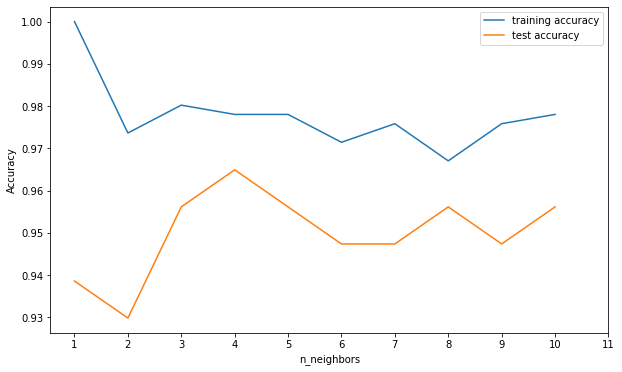

In [59]:
#近傍オブジェクト数に対して訓練、テストスコアをプロットする
fig = plt.figure(figsize = (10,6))
plt.plot(List_n_neighbors, List_train_score, label = "training accuracy")
plt.plot(List_n_neighbors, List_test_score, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.xticks(np.linspace(1,11,11))
plt.legend()

Cancer Datasetを用いた予測においては**近傍オブジェクト数(k)がk=4あたりが最良の性能**であることがうかがえます。<br>
ただしK=2の場合でも93%程度の精度が担保されており、特徴量30程度のCancer Datasetに関してはNearest Neighbor Classificationによる分類は十分に機能しているように見えます。

# 6. 分類モデルの評価指標での確認

以下classification_reportによる結果を確認しても再現率(recall)、適合率(precision)ともに大きな偏りなく精度を保っていることが確認できます。

ただし実際に実務上、ガンの診断に使えるかというと以下classification_reportによる結果を確認すると悪性腫瘍の再現率(recall)の精度から悪性47件のうち3件程度は悪性腫瘍を良性と判断してしまう点から残念ながら実用化は難しいと思われます。


In [65]:
clf = KNeighborsClassifier(n_neighbors = 4).fit(X_train,y_train)
predict_result = clf.predict(X_test)
print(classification_report(y_test,predict_result, target_names=["悪性","良性" ]))

              precision    recall  f1-score   support

          悪性       0.98      0.94      0.96        47
          良性       0.96      0.99      0.97        67

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

